In [5]:
# import all the relevant libraries. Many will need installation.
import tsfel
import wfdb
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, hamming_loss
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from mne.datasets import sample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold,train_test_split
from mne_features.feature_extraction import extract_features
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

C:\Users\piotr\anaconda_projects\anaconda3\Lib\site-packages\mne_features\mock_numba.py:12: UserWarning: Numba needs NumPy 2.0 or less. Got NumPy 2.2.. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [9]:
# This function takes in the record path of a PSG file and outputs the raw annotated data. It renames, changes types and removes channels so that they
# are consistent between different patients. Some patients had more/less data collected through different manners which had to be fixed.
def raw_data_compiler(record_path):
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'st')
    
    annotation_mne = mne.Annotations(
        onset=annotation.sample / record.fs,
        duration=30,
        description=annotation.aux_note
    )
    
    signals = record.p_signal  # Signal data as NumPy array
    sampling_rate = record.fs  # Sampling frequency (e.g., 250 Hz)
    channel_names = record.sig_name  # Channel names
    seen_categories = set()
    
    # Assign types while ensuring only the first occurrence is assigned correctly
    channel_types = []
    channel_names_updated = []
    
    for ch in channel_names:
        if "EEG" in ch and "EEG" not in seen_categories:
            channel_types.append("eeg")
            channel_names_updated.append("EEG")
            seen_categories.add("EEG")
        elif "Resp" in ch and "Resp" not in seen_categories:
            channel_types.append("resp")
            channel_names_updated.append("Respiratory")
            seen_categories.add("Resp")
        elif "ECG" in ch and "ECG" not in seen_categories:
            channel_types.append("ecg")
            channel_names_updated.append("ECG")
            seen_categories.add("ECG")
        else:
            channel_types.append("misc")
            channel_names_updated.append(ch)
    # Create MNE Info object
    info = mne.create_info(
        ch_names=channel_names_updated,
        sfreq=sampling_rate,
        ch_types=channel_types
    )
    # Convert signals to MNE RawArray
    raw = mne.io.RawArray(signals.T, info)
    
    # Add annotations to the raw object
    raw.set_annotations(annotation_mne)
    misc_channels = [ch for ch, ch_type in zip(channel_names_updated, channel_types) if "misc" in ch_type]
    raw.drop_channels(misc_channels)
    
    return raw

In [13]:
# compile a list of raw data for each subject and combine it into a single large raw file.
List_of_subjects=open(r"\Users\piotr\Desktop\PSG data\List of subjects.txt","r").read().split("\n")
list_of_raw_data=[]
for i in List_of_subjects:
    record_path = fr"C:\Users\piotr\Desktop\PSG data\MIT Data\{i}"
    list_of_raw_data.append(raw_data_compiler(record_path))
raw=mne.concatenate_raws(list_of_raw_data)

Creating RawArray with float64 data, n_channels=4, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  7199.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=2700000
    Range : 0 ... 2699999 =      0.000 ... 10799.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=2700000
    Range : 0 ... 2699999 =      0.000 ... 10799.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=2025000
    Range : 0 ... 2024999 =      0.000 ...  8099.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range

In [15]:
# Reclassify events. The original annotations had descriptions that were not relevant to this classifier. Everything is relabled either
event_labels = {
    0: "Awake",
    1: "Stage 1",
    2: "Stage 2",
    3: "Stage 3",
    4: "Stage 4",
    5: "REM"
}
new_id = {}
for desc in raw.annotations.description:
    if "R" in desc: 
        new_id[desc] = 5
    elif "W" in desc:  # Obstructive Apnea
        new_id[desc] = 0
    elif "1" in desc :  # Central Apnea
        new_id[desc] = 1
    elif "2" in desc :  # Central Apnea
        new_id[desc] = 2
    elif "3" in desc :  # Central Apnea
        new_id[desc] = 3
    elif "4" in desc :  # Central Apnea
        new_id[desc] = 4
    elif "5" in desc :  # Central Apnea
        new_id[desc] = 5

# Generate events with the new mapping
events, event_id = mne.events_from_annotations(raw, event_id=new_id)

new_annotations = mne.Annotations(
    onset=events[:, 0] / raw.info["sfreq"],  # Convert sample index to seconds
    duration=[30] * len(events),  # Assume each event lasts 30 seconds
    description=[event_labels[e] for e in events[:, 2]]  # Convert IDs back to labels
)

Used Annotations descriptions: [np.str_('1'), np.str_('1 A'), np.str_('1 A X'), np.str_('1 CA'), np.str_('1 CAA'), np.str_('1 CAA CAA'), np.str_('1 CAA CAA L'), np.str_('1 CAA HA'), np.str_('1 CAA X'), np.str_('1 H'), np.str_('1 H H'), np.str_('1 H HA'), np.str_('1 H X'), np.str_('1 HA'), np.str_('1 HA CA'), np.str_('1 HA CAA'), np.str_('1 HA H'), np.str_('1 HA HA'), np.str_('1 HA L'), np.str_('1 HA X'), np.str_('1 L'), np.str_('1 L L'), np.str_('1 LA'), np.str_('1 LA LA'), np.str_('1 LA X'), np.str_('1 OA'), np.str_('1 OA OA'), np.str_('1 OA X'), np.str_('1 X'), np.str_('1 X H'), np.str_('1 X L'), np.str_('1 X X'), np.str_('2'), np.str_('2 A'), np.str_('2 A A A'), np.str_('2 CA'), np.str_('2 CAA'), np.str_('2 H'), np.str_('2 H H'), np.str_('2 H HA'), np.str_('2 H L'), np.str_('2 H LA'), np.str_('2 HA'), np.str_('2 HA H'), np.str_('2 HA HA'), np.str_('2 HA L'), np.str_('2 HA X'), np.str_('2 L'), np.str_('2 L A'), np.str_('2 L H'), np.str_('2 L HA'), np.str_('2 L L'), np.str_('2 L LA'),

In [21]:
# Set the new annotations in copies of raw and split the data into train and test. About 80/20 split. Also extracting events, to know when what happend.
raw_copy1=raw.copy().set_annotations(new_annotations)
raw_copy2=raw.copy().set_annotations(new_annotations)
raw_train,raw_test=raw_copy1.crop(tmin=0,tmax=245000),raw_copy2.crop(tmin=245001)
events_train, event_id_train = mne.events_from_annotations(raw_train)
events_test, event_id_test = mne.events_from_annotations(raw_test)
print(raw_train.times[-1]/(raw_train.times[-1]+raw_test.times[-1]))

Used Annotations descriptions: [np.str_('Awake'), np.str_('REM'), np.str_('Stage 1'), np.str_('Stage 2'), np.str_('Stage 3'), np.str_('Stage 4')]
Used Annotations descriptions: [np.str_('Awake'), np.str_('REM'), np.str_('Stage 1'), np.str_('Stage 2'), np.str_('Stage 3'), np.str_('Stage 4')]
0.7948893584741935


Using matplotlib as 2D backend.


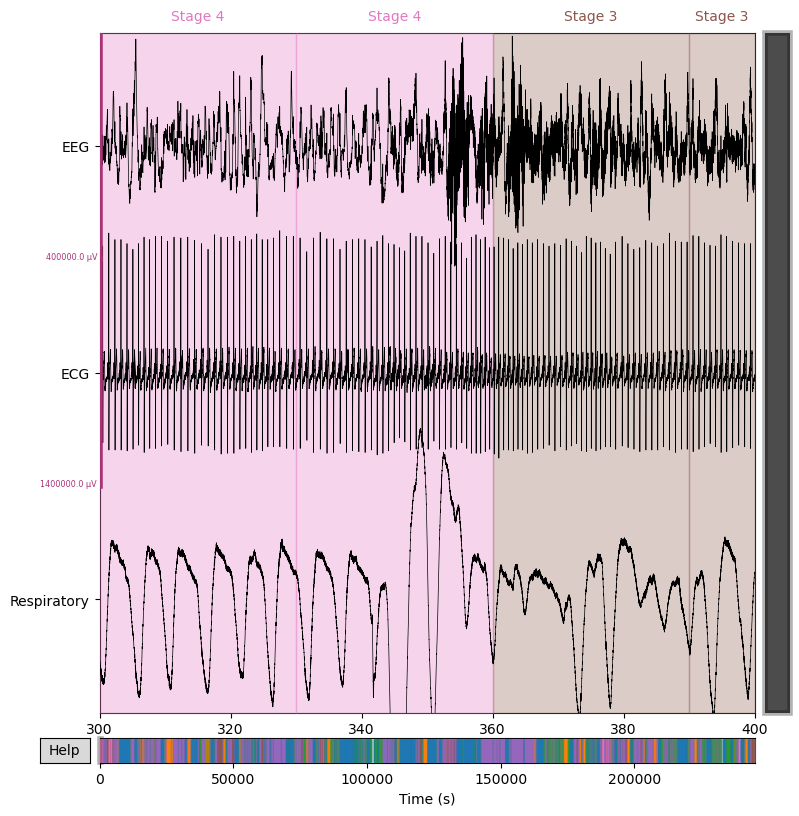

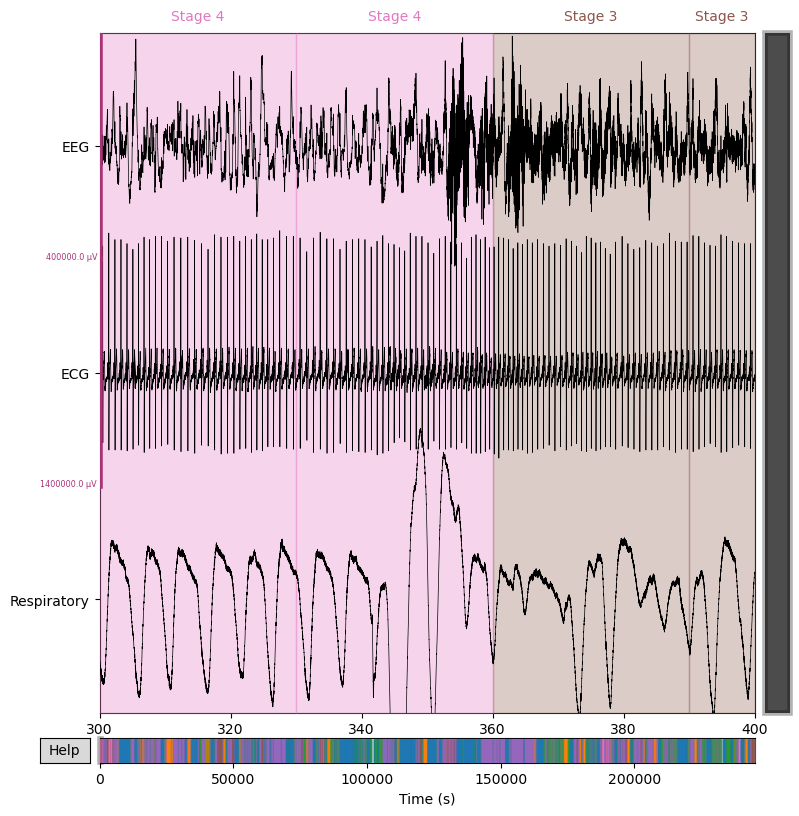

In [23]:
# plotting an event jsut to make sure annotations are correct.
raw_train.plot(start=300,duration=100,color="k",
            picks=["ECG",'Respiratory',"EEG"],
            scalings=dict(eeg=0.2,  ecg=0.7, resp=1))

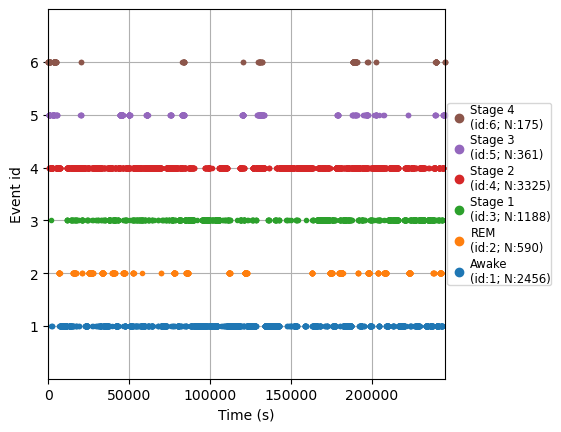

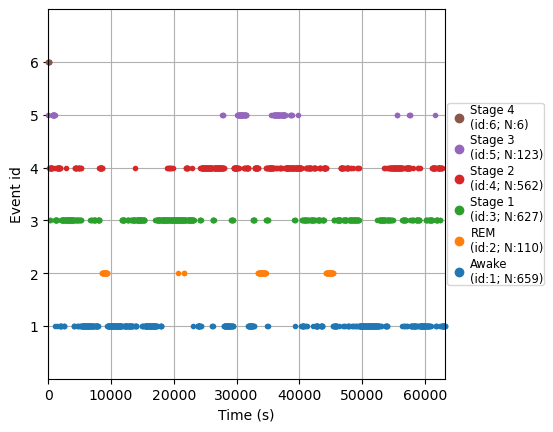

In [35]:
# Plotting the types of events happening at each time.
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id_train,
    sfreq=raw_train.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw_train.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()
import matplotlib.pyplot as plt
# Plot the events
fig = mne.viz.plot_events(
    events_test,
    event_id=event_id_test,
    sfreq=raw_test.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw_test.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()

In [48]:
# creating epochs (windowed data essentially) for the events previously extracted.
tmax = 30.0 - 1.0 / raw.info["sfreq"]  # tmax in included
epochs_train = mne.Epochs(
    raw_train,
    events=events_train,
    event_id=event_id_train,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    preload=True,
    picks=["ECG",'Respiratory',"EEG"]
).resample(sfreq=10)
epochs_test=mne.Epochs(
    raw_test,
    events=events_test,
    event_id=event_id_test,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    preload=True,
    event_repeated="merge",
    picks=["ECG",'Respiratory',"EEG"]
).resample(sfreq=10)

Not setting metadata
8095 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8095 events and 7500 original time points ...
1 bad epochs dropped
Not setting metadata
2087 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2087 events and 7500 original time points ...
0 bad epochs dropped


In [51]:
# We now extract the features from each epoch, we extract many features and we will reduce dimensions later.
# We use the mne_features package to save us some trouble. Since the data has three channels each epoch consists of 3 times series
data_train = epochs_train.get_data()
data_test =epochs_test.get_data()
selected_funcs = {'mean', 'ptp_amp', 'std',"variance","skewness","kurtosis","rms"}
y_train = epochs_train.events[:, 2]
y_test = epochs_test.events[:, 2]
X_train = extract_features(data_train, 101, selected_funcs)
X_test = extract_features(data_test, 101, selected_funcs)

In [93]:
# we now have all the data ready so we creaated a pipline, we scale the data, select features and learn.
pipe = Pipeline([('scaling', StandardScaler()),("selection", SelectKBest(f_classif, k=5)),
                 ('learning', GradientBoostingClassifier( n_estimators=200,  # Increase estimators to generalize better
        max_depth=3,       # Reduce tree depth (default is 3)
        learning_rate=0.05, # Lower learning rate for stability
        random_state=42))])

In [99]:
# we now train the model and test it. Since the data set is unbalanced we introduce sample weights.
# class_weights = compute_sample_weight(class_weight="balanced", y=y_train)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
report=classification_report(y_test,y_pred)
print(report)

0.2879731672256828
              precision    recall  f1-score   support

           1       0.27      0.46      0.34       659
           2       0.00      0.00      0.00       110
           3       0.35      0.32      0.33       627
           4       0.43      0.17      0.24       562
           5       0.45      0.04      0.07       123
           6       0.07      0.17      0.10         6

    accuracy                           0.29      2087
   macro avg       0.26      0.19      0.18      2087
weighted avg       0.33      0.29      0.28      2087



In [103]:
y_pred = pipe.predict(X_train)
acc = accuracy_score(y_train, y_pred)
report=classification_report(y_train,y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.69      0.63      0.66      2456
           2       0.80      0.41      0.55       590
           3       0.65      0.31      0.42      1188
           4       0.63      0.85      0.72      3325
           5       0.81      0.55      0.66       360
           6       0.85      0.79      0.82       175

    accuracy                           0.66      8094
   macro avg       0.74      0.59      0.64      8094
weighted avg       0.67      0.66      0.65      8094



In [122]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
class_weights = compute_sample_weight(class_weight="balanced", y=y_train)
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
class_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# List of classifiers that support sample_weight
sample_weight_supported = {
    "SVC", "DecisionTreeClassifier", "RandomForestClassifier",
    "AdaBoostClassifier", "GaussianNB"
}

# Iterate over classifiers
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf) 
    
    # Get classifier step name
    clf_step_name = pipe.steps[-1][0]  
    
    # Check if classifier supports sample_weight
    if clf.__class__.__name__ in sample_weight_supported:
        pipe.fit(X_train, y_train, **{f"{clf_step_name}__sample_weight": class_weights}) 
    else:
        pipe.fit(X_train, y_train)  
    
    # Evaluate performance
    score = pipe.score(X_test, y_test)
    print(f"{name} has score of:", score)

Nearest Neighbors has score of: 0.5678006708193579
Linear SVM has score of: 0.40728318160038335
RBF SVM has score of: 0.5170100622903689
Gaussian Process has score of: 0.6425491135601341
Decision Tree has score of: 0.5481552467656924
Random Forest has score of: 0.5352180162913273
Neural Net has score of: 0.610924772400575
AdaBoost has score of: 0.460469573550551
Naive Bayes has score of: 0.3747005270723527


TypeError: QuadraticDiscriminantAnalysis.fit() got an unexpected keyword argument 'sample_weight'